# Risk-Aware Decision System with Abstention

This notebook demonstrates an end-to-end workflow for building a high-reliability ML system using the UCI Adult dataset.

### Key Features:
- **Probabilistic Modeling**: LightGBM with calibrated outputs.
- **Uncertainty Estimation**: Quantifying prediction confidence.
- **Decision Policy**: Optimizing thresholds `tau_low`, `tau_high` to minimize asymmetric costs.
- **Evaluation**: Risk-Coverage analysis and Cost Reduction metrics.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Modern KAIROS Imports
from src.kairos.data.loader import load_adult_data
from src.kairos.data.transformers import AdultFeatureEngineer
from src.kairos.core.models import HybridEnsemble
from src.kairos.core.calibration import compute_ece
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from src.kairos.core.policy import KairosPolicy, compute_cost, Action
from src.kairos.tracking.metrics import evaluate_policy

## 1. Data Loading & Preprocessing
We load the Adult dataset, handle missing values, and perform one-hot encoding using our unified pipeline.

In [2]:
df = load_adult_data('../data')
X = df.drop(columns=['target', 'income', 'fnlwgt', 'education'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 31258
Val size: 7815
Test size: 9769


## 2. Feature Engineering & Training
We use the `AdultFeatureEngineer` to transform the raw dataframe into numerical features, then train the Hybrid Ensemble.

In [3]:
# Create Feature Pipeline
engineer = AdultFeatureEngineer()
X_train_proc = engineer.fit_transform(X_train)
X_val_proc = engineer.transform(X_val)
X_test_proc = engineer.transform(X_test)

# Fix: LightGBM requires specific dtypes for categorical features (not 'object')
for col in X_train_proc.select_dtypes(['object']).columns:
    X_train_proc[col] = X_train_proc[col].astype('category')
    X_val_proc[col] = X_val_proc[col].astype('category')
    X_test_proc[col] = X_test_proc[col].astype('category')

# Initialize & Train Ensemble
ensemble = HybridEnsemble(
    lgb_params={'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100},
    cat_params={'learning_rate': 0.05, 'depth': 5, 'iterations': 100}
)
ensemble.fit(X_train_proc, y_train)
print("Training Complete.")

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 25006, number of used features: 18
[LightGBM] [Warning] Provided parameters cons

## 3. Calibration
Models like Boosted Trees can be overconfident. We inspect the reliability curve.

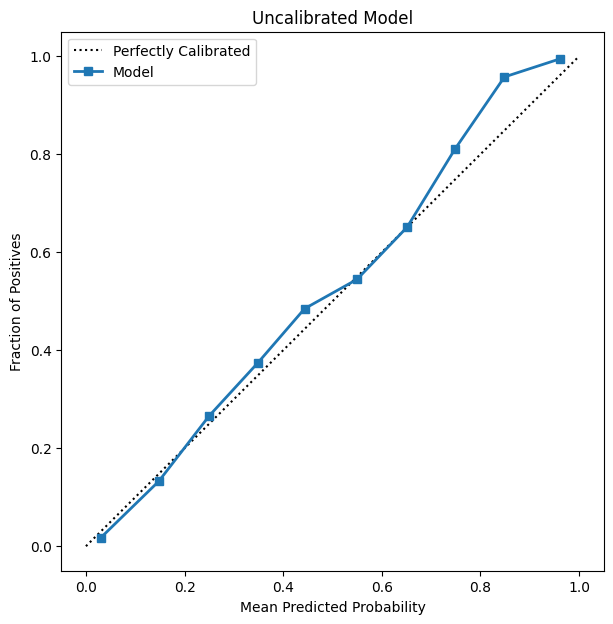

In [4]:
val_probs = ensemble.predict_proba(X_val_proc)[:, 1]

def plot_reliability(y_true, y_prob, title="Reliability Diagram"):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.figure(figsize=(7, 7))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
    plt.plot(prob_pred, prob_true, "s-", label="Model", linewidth=2)
    plt.title(title)
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()

plot_reliability(y_val, val_probs, "Uncalibrated Model")

## 4. Policy Simulation
We minimize the ASYMMETRIC cost of errors vs abstaining.

In [5]:
# Simulate KAIROS Policy Logic locally
tau_low, tau_high = 0.2, 0.8
policy = KairosPolicy(tau_low, tau_high)

test_probs = ensemble.predict_proba(X_test_proc)[:, 1]
decisions = policy.predict_with_policy(test_probs)

metrics = evaluate_policy(y_test.values, test_probs, tau_low, tau_high)
print("Policy Performance:", metrics)

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[0 1] and y_pred=['ACCEPT' 'REJECT']. Make sure that the predictions provided by the classifier coincides with the true labels.